In [1]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

!pip install boruta
!pip install xgboost
!pip install optuna

from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from boruta import BorutaPy
import seaborn as sns
import pandas as pd
import optuna

In [2]:
df = pd.read_csv('Breast Cancer Wisconsin (Diagnostic) Data Set.csv')
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


id                           0
diagnosis                    0
radius_mean                  0
texture_mean                 0
perimeter_mean               0
area_mean                    0
smoothness_mean              0
compactness_mean             0
concavity_mean               0
concave points_mean          0
symmetry_mean                0
fractal_dimension_mean       0
radius_se                    0
texture_se                   0
perimeter_se                 0
area_se                      0
smoothness_se                0
compactness_se               0
concavity_se                 0
concave points_se            0
symmetry_se                  0
fractal_dimension_se         0
radius_worst                 0
texture_worst                0
perimeter_worst              0
area_worst                   0
smoothness_worst             0
compactness_worst            0
concavity_worst              0
concave points_worst         0
symmetry_worst               0
fractal_dimension_worst      0
Unnamed:

<Axes: >

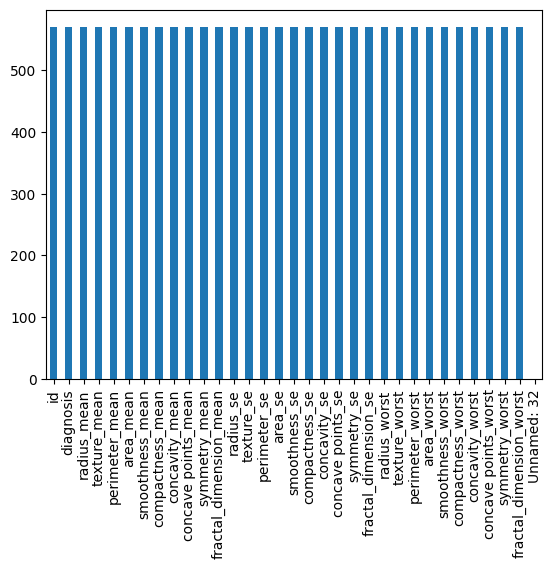

In [3]:
# Check for missing data
print(df.isnull().sum())
df.count().plot(kind='bar')

In [4]:
print(df.duplicated().sum())

0


In [5]:
drop_list = ['Unnamed: 32', 'id']
df = df.drop(drop_list, axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    object 
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

In [6]:
df.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


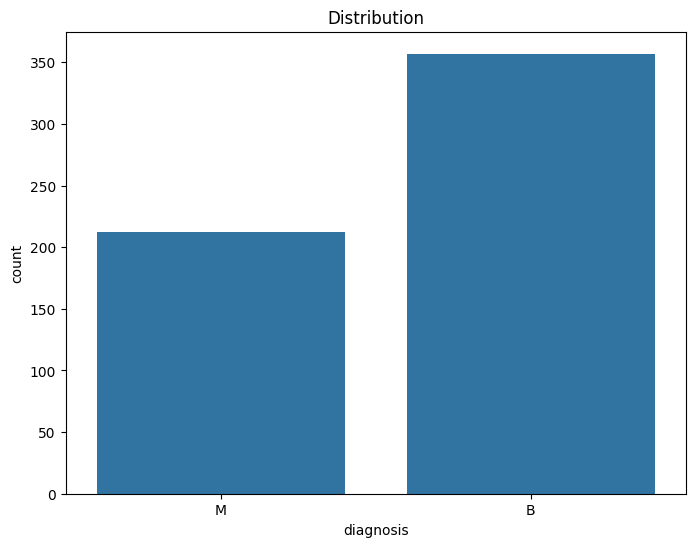

Benign: 357, Malignant: 212


In [7]:
plt.figure(figsize=(8, 6))
sns.countplot(x='diagnosis', data=df)
plt.title('Distribution')
plt.show()

counts = df['diagnosis'].value_counts()
print(f'Benign: {counts["B"]}, Malignant: {counts["M"]}')

In [8]:
df_target = df.diagnosis
df_features = df.drop('diagnosis', axis=1)
df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   radius_mean              569 non-null    float64
 1   texture_mean             569 non-null    float64
 2   perimeter_mean           569 non-null    float64
 3   area_mean                569 non-null    float64
 4   smoothness_mean          569 non-null    float64
 5   compactness_mean         569 non-null    float64
 6   concavity_mean           569 non-null    float64
 7   concave points_mean      569 non-null    float64
 8   symmetry_mean            569 non-null    float64
 9   fractal_dimension_mean   569 non-null    float64
 10  radius_se                569 non-null    float64
 11  texture_se               569 non-null    float64
 12  perimeter_se             569 non-null    float64
 13  area_se                  569 non-null    float64
 14  smoothness_se            5

In [10]:
# Binary Encoding for Diagnosis
df_target = df_target.map({'B': 1, 'M': 0})

In [11]:
clf_xgb = XGBClassifier(
    n_jobs=-1,
    use_label_encoder=False,
    eval_metric='logloss'
)

boruta_xgb = BorutaPy(
    estimator=clf_xgb,
    n_estimators=500,
    random_state=42,
    verbose=0
)

boruta_xgb.fit(df_features.values, df_target.values.ravel())

print("\nTraining with XGBoost + Boruta Completed")
print(f'Confirmed features: {boruta_xgb.n_features_}')
print('Selected Features:')

selected_features_xgb = df_features.columns[boruta_xgb.support_]
for feature in selected_features_xgb:
    print(f" - {feature}")

print(f'\nTentative features: {sum(boruta_xgb.support_weak_)}')
if sum(boruta_xgb.support_weak_) > 0:
    tentative_features = df_features.columns[boruta_xgb.support_weak_]
    print('Tentative Features:')
    for feature in tentative_features:
        print(f" - {feature}")


Training with XGBoost + Boruta Completed
Confirmed features: 9
Selected Features:
 - texture_mean
 - concave points_mean
 - radius_se
 - radius_worst
 - texture_worst
 - perimeter_worst
 - area_worst
 - concavity_worst
 - concave points_worst

Tentative features: 0


In [12]:
df_3 = df[selected_features_xgb]
df_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   texture_mean          569 non-null    float64
 1   concave points_mean   569 non-null    float64
 2   radius_se             569 non-null    float64
 3   radius_worst          569 non-null    float64
 4   texture_worst         569 non-null    float64
 5   perimeter_worst       569 non-null    float64
 6   area_worst            569 non-null    float64
 7   concavity_worst       569 non-null    float64
 8   concave points_worst  569 non-null    float64
dtypes: float64(9)
memory usage: 40.1 KB


In [14]:
from sklearn.model_selection import train_test_split

# Train (%60), Validation (%20) ve Test (%20)
X_train, X_temp, y_train, y_temp = train_test_split(df_3, df_target, test_size=0.4, random_state=42, stratify=df_target)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

X_train_full = pd.concat([X_train, X_val])
y_train_full = pd.concat([y_train, y_val])

In [15]:
# We will need scale_pos_weight to balance dataset while training with XBGoost and Catboost
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
print(f"scale_pos_weight value: {scale_pos_weight:.2f}")

scale_pos_weight value: 0.59


In [17]:
from sklearn.metrics import (recall_score,precision_score,f1_score,
                             accuracy_score,roc_auc_score,classification_report)

In [18]:
# XGBoost - Boruta chosen features - roc_auc

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'random_state': 42,
        'n_jobs': -1,
        'scale_pos_weight': scale_pos_weight,   # IMPORTANT
        'early_stopping_rounds': 50,
    }

    clf = XGBClassifier(**params)
    clf.fit(X_train, y_train,
            eval_set=[(X_val, y_val)],
            verbose=False)

    y_val_proba = clf.predict_proba(X_val)[:, 1]
    val_roc_auc = roc_auc_score(y_val, y_val_proba)
    return val_roc_auc

# ROC AUC optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1000, show_progress_bar=True)

print("\nOptimization Complete")
print("Best Trial:")
best_trial = study.best_trial
print(f"  Value (Validation ROC AUC): {best_trial.value:.4f}")
print("  Best hiperparameters: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

print("\n MODEL PERFORMANS ")
final_model = XGBClassifier(
    **best_trial.params,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1
)
final_model.fit(X_train_full, y_train_full)

# Predict on Test Set
y_pred = final_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

[I 2025-09-29 20:32:34,080] A new study created in memory with name: no-name-72221dd6-1d87-4132-9bfb-4f030d3553c5


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2025-09-29 20:32:34,240] Trial 0 finished with value: 0.9966931216931217 and parameters: {'n_estimators': 807, 'max_depth': 6, 'learning_rate': 0.038245941315430576, 'subsample': 0.6172490102802047, 'colsample_bytree': 0.8714496053443406, 'gamma': 2.981656155189314}. Best is trial 0 with value: 0.9966931216931217.
[I 2025-09-29 20:32:34,331] Trial 1 finished with value: 0.9963624338624338 and parameters: {'n_estimators': 1249, 'max_depth': 6, 'learning_rate': 0.04866102647278637, 'subsample': 0.8645886520241424, 'colsample_bytree': 0.915828266992305, 'gamma': 3.3916011528711336}. Best is trial 0 with value: 0.9966931216931217.
[I 2025-09-29 20:32:34,473] Trial 2 finished with value: 0.996031746031746 and parameters: {'n_estimators': 1845, 'max_depth': 4, 'learning_rate': 0.03002306056376712, 'subsample': 0.9733396064512496, 'colsample_bytree': 0.7802718766664697, 'gamma': 4.806426500844847}. Best is trial 0 with value: 0.9966931216931217.
[I 2025-09-29 20:32:34,645] Trial 3 finished

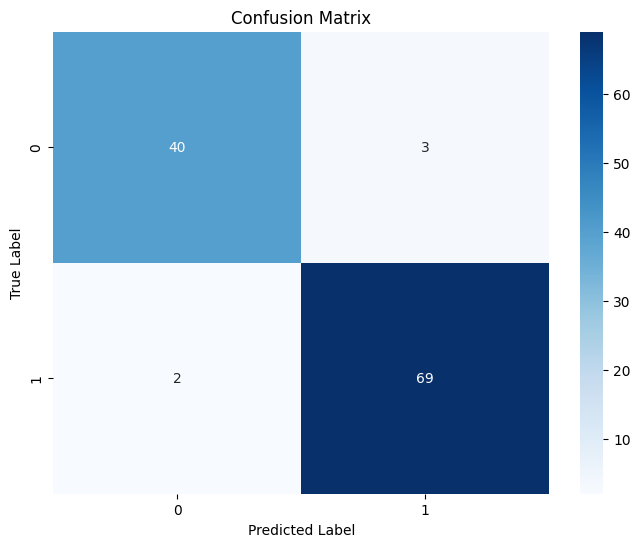


Confusion Matrix:
True Negatives: 40
False Positives: 3
False Negatives: 2
True Positives: 69


In [21]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print(f"\nConfusion Matrix:")
print(f"True Negatives: {cm[0,0]}")
print(f"False Positives: {cm[0,1]}")
print(f"False Negatives: {cm[1,0]}")
print(f"True Positives: {cm[1,1]}")

In [19]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation
cv_scores = cross_val_score(final_model, X_train_full, y_train_full, cv=5, scoring='roc_auc')

print(f"\nCross-Validation ROC AUC Scores: {cv_scores}")
print(f"Mean Cross-Validation ROC AUC: {cv_scores.mean():.4f}")
print(f"Standard Deviation of Cross-Validation ROC AUC: {cv_scores.std():.4f}")


Cross-Validation ROC AUC Scores: [0.98484848 0.96904025 0.99484004 0.99845201 0.999484  ]
Mean Cross-Validation ROC AUC: 0.9893
Standard Deviation of Cross-Validation ROC AUC: 0.0114
